# HW10: Algorithmic Fairness 

### Note: to complete most of this homework notions from week 11 slides are needed

In this homework you will assess racial bias in the COMPAS algorithm and judges decisions. 

The data is a collection of 7000 criminal cases in Florida in which COMPAS was used and it contains information about defendants' demographics, criminal history (e.g., juvenile criminal records), court decision and recidivism.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

## Data Preparation

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [4]:
df['days_from_recid'] = pd.to_datetime(df['r_offense_date']) - pd.to_datetime(df['c_offense_date'])
df['days_from_recid'] = df['days_from_recid'].dt.days
df['two_year_recid2'] = (df['days_from_recid']<=730).astype(int)

#generate felony charge dummies
df['felony'] = (df['c_charge_degree'] == 'F').astype(int)

#generate age dummies
d = pd.get_dummies(df['age_cat'])
df = pd.concat([df, d], axis=1)
df = df.rename(columns={'25 - 45':'age_cat_25 - 45', 'Greater than 45':'age_cat_Greater than 45', 'Less than 25':'age_cat_Less than 25'})

#generate ethnicity, race and compas score dummies
d = pd.get_dummies(df['race'])
df = pd.concat([df, d], axis=1)
df['male'] = (df['sex'] == 'Male').astype(int)
d = pd.get_dummies(df['score_text'])
df = pd.concat([df, d], axis=1)
df = df.rename(columns={'High':'score_text_high', 'Medium':'score_text_medium', 'Low':'score_text_low'})

### Setting outcomes and predictors

The *ideal* target variable for the COMPAS algorithm is the presence of a recidivism episode, while for judges is the decision to send the defendant to jail. For the predictors we use some deomgraphic characteristics **excluding race**, criminal hisotry and type of crime. 

In [5]:
# judge decision: "jailed" = more than one day in jail.
df['jail_days'] = pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])
df['jailed'] = (df.jail_days.dt.days > 1).astype(int)
D = df['jailed']
D.value_counts()

0    4283
1    2931
Name: jailed, dtype: int64

In [6]:
# Algorithm outcome
Y = df['two_year_recid2'] 
Y.value_counts()

0    4557
1    2657
Name: two_year_recid2, dtype: int64

In [7]:
# predictors
predictors = ['felony',
              'male', 'age', 
              'juv_fel_count','juv_misd_count', 'juv_other_count', 'priors_count']
X = df[predictors]
X.describe()

,felony,male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,0.646798,0.806626,34.817993,0.067230,0.090934,0.109371,3.472415
std,0.477998,0.394971,11.888922,0.473972,0.485239,0.501586,4.882538
min,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,1.000000,42.000000,0.000000,0.000000,0.000000,5.000000
max,1.000000,1.000000,96.000000,20.000000,13.000000,17.000000,38.000000


In [8]:
df['race'].value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

In [9]:
# indicator variable for non-white
NW = (df['race'] != 'Caucasian').astype(int)
NW.describe()

count    7214.000000
mean        0.659828
std         0.473800
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: race, dtype: float64

## Assessing Algorithm: Predict Recidivism from Features

In the following you will predict recidivism from defendants' features using a nested training/test split so we can get clean test-set predictions for the whole dataset (see the notebook and homework on double machine learning for how to do this - week 6).

In [10]:
# perform nested train/test split 
from sklearn.model_selection import train_test_split
X_a, X_b, Y_a, Y_b, D_a, D_b,NW_a, NW_b = train_test_split(X, Y, D, NW, test_size = 0.5)

df_pred = X_a.append(X_b) 
#TODO train a logit model to predict recidism (Y) from predictors (X).
#TODO form clean test-set predictions for recidivism in the full dataset
from sklearn.linear_model import LogisticRegression

logit_a = LogisticRegression()
logit_a.fit(X_a, Y_a)
Y_bhat = logit_a.predict(X_b) # Predict the actual value
Y_bprob = logit_a.predict_proba(X_b)[:, 1] # Class probabilities of each data

logit_b = LogisticRegression()
logit_b.fit(X_b, Y_b)
Y_ahat = logit_b.predict(X_a)
Y_aprob = logit_b.predict_proba(X_a)[:, 1]


Y_adf = Y_a.to_frame()
Y_adf['two_year_recid2_hat'] = Y_ahat
Y_adf['two_year_recid2_prob'] = Y_aprob

Y_bdf = Y_b.to_frame()
Y_bdf['two_year_recid2_hat'] = Y_bhat
Y_bdf['two_year_recid2_prob'] = Y_bprob

Y_pred = Y_adf.append(Y_bdf)
df_pred = df_pred.merge(Y_pred, left_index=True, right_index=True)
df_pred.head(5)

,felony,male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid2,two_year_recid2_hat,two_year_recid2_prob
526,1,1,24,0,0,0,0,0,0,0.380252
4000,0,1,27,0,0,0,0,0,0,0.352037
4374,1,1,39,0,0,0,35,0,1,0.909815
5212,1,1,27,0,0,0,0,0,0,0.354660
2522,1,1,56,0,0,0,1,0,0,0.172561


Evaluate test set performance.

              precision    recall  f1-score   support

           0       0.67      0.91      0.77      4557
           1       0.59      0.22      0.32      2657

    accuracy                           0.66      7214
   macro avg       0.63      0.56      0.54      7214
weighted avg       0.64      0.66      0.60      7214

False Positive/False Negative:  0.19107057129140662


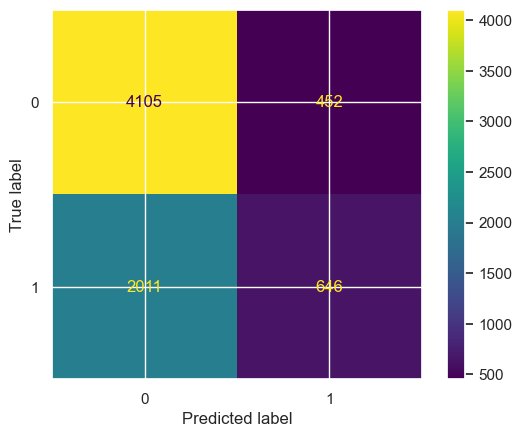

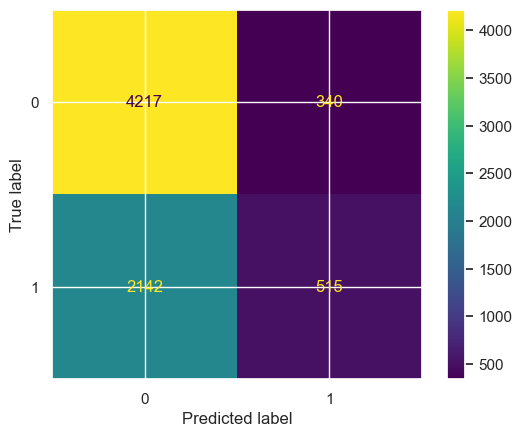

In [11]:
#TODO show a confusion matrix, compute accuracy, balanced accuracy, and roc_auc
#TODO compute ratio of false positives to false negatives

# Confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plot_confusion_matrix(logit_a, df_pred[predictors], df_pred['two_year_recid2'])
plot_confusion_matrix(logit_b, df_pred[predictors], df_pred['two_year_recid2'])

# Accuracy, balanced accuracy and roc_auc
from sklearn.metrics import classification_report
print(classification_report(df_pred['two_year_recid2'], df_pred['two_year_recid2_hat']))

# Ratio of false positives to false negatives
tn, fp, fn, tp = confusion_matrix(df_pred['two_year_recid2'], df_pred['two_year_recid2_hat']).ravel()
print('False Positive/False Negative: ', fp/fn)

### Compare treatment of whites and non-whites for recidivism prediction
##### Refer to week 11 for these concepts

#### Base Rates

In [12]:
##TODO Compare base rates for recidivism outcomes of whites and non-whites

br_white = df.loc[df['race'] == 'Caucasian', 'two_year_recid2'].sum()/df[df['race'] == 'Caucasian'].count()['race']
br_non_white = df.loc[df['race'] != 'Caucasian', 'two_year_recid2'].sum()/df.loc[df['race'] != 'Caucasian'].count()['race']
br_white, br_non_white

(0.3280358598207009, 0.38907563025210085)

#### Performance

In [13]:
##TODO Produce confusion matrices, classification reports, and ratio of false positives to false negatives, separately for whites and non-whites.

df_pred=df_pred.merge(df['race'],left_index=True,right_index=True)
df_pred_white = df_pred[df_pred['race']=='Caucasian']
df_pred_non_white = df_pred[df_pred['race']!='Caucasian']

print('Whites')
print(classification_report(df_pred_white['two_year_recid2'], df_pred_white['two_year_recid2_hat']))
print(confusion_matrix(df_pred_white['two_year_recid2'], df_pred_white['two_year_recid2_hat']))
tn, fp, fn, tp = confusion_matrix(df_pred_white['two_year_recid2'], df_pred_white['two_year_recid2_hat']).ravel()
print('False Positive/False Negative: ', fp/fn)

print ('')

print('Non-Whites')
print(classification_report(df_pred_non_white['two_year_recid2'], df_pred_non_white['two_year_recid2_hat']))
print(confusion_matrix(df_pred_non_white['two_year_recid2'], df_pred_non_white['two_year_recid2_hat']))
tn, fp, fn, tp = confusion_matrix(df_pred_non_white['two_year_recid2'], df_pred_non_white['two_year_recid2_hat']).ravel()
print('False Positive/False Negative: ', fp/fn)


Whites
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      1649
           1       0.57      0.13      0.21       805

    accuracy                           0.68      2454
   macro avg       0.63      0.54      0.51      2454
weighted avg       0.65      0.68      0.61      2454

[[1568   81]
 [ 699  106]]
False Positive/False Negative:  0.11587982832618025

Non-Whites
              precision    recall  f1-score   support

           0       0.65      0.89      0.75      2908
           1       0.60      0.25      0.35      1852

    accuracy                           0.64      4760
   macro avg       0.62      0.57      0.55      4760
weighted avg       0.63      0.64      0.60      4760

[[2591  317]
 [1384  468]]
False Positive/False Negative:  0.22904624277456648


**What concepts of "fairness" (from class) are (approximately) satisfied by this classifier? Explain.**

- Accuracy is very similar (0.68 and 0.64).
- fp/fn ratio is 0.13 vs 0.22. Therefore, treatment quality is not achieved.

## Assessing Judges' Decisions: Predict Judge Decision from Features

In the following you will predict judges' decisions from defendants' features using a nested training/test split as before. In a second model, include Y-hat from previous section as a predictor.

In [14]:
#TODO train a logit model to predict judge decision (D) from predictors (X). 

logit_a = LogisticRegression()
logit_a.fit(X_a, D_a)
D_bhat = logit_a.predict(X_b)
D_bprob = logit_a.predict_proba(X_b)[:, 1]
logit_b = LogisticRegression()
logit_b.fit(X_b, D_b)
D_ahat = logit_b.predict(X_a)
D_aprob = logit_b.predict_proba(X_a)[:, 1]

D_adf = D_a.to_frame()
D_adf['jailed_hat'] = D_ahat
D_adf['jailed_prob'] = D_aprob
D_bdf = D_b.to_frame()
D_bdf['jailed_hat'] = D_bhat
D_bdf['jailed_prob'] = D_bprob

In [15]:
#TODO train a logit model to predict judge decision (D) from predictors (X) and predicted recidivism risk (Yhat)
#TODO form clean test-set predictions for the decisions in the full dataset
XY_a = df_pred[predictors].iloc[X_a.index]
XY_b = df_pred[predictors].iloc[X_b.index]
logit_a = LogisticRegression()
logit_a.fit(XY_a, D_a)
D_bhat = logit_a.predict(XY_b)
D_bprob = logit_a.predict_proba(XY_b)[:, 1]
logit_b = LogisticRegression()
logit_b.fit(XY_b, D_b)
D_ahat = logit_b.predict(XY_a)
D_aprob = logit_b.predict_proba(XY_a)[:, 1]

D_adf['jailed_Y_hat'] = D_ahat
D_adf['jailed_Y_prob'] = D_aprob
D_bdf['jailed_Y_hat'] = D_bhat
D_bdf['jailed_Y_prob'] = D_bprob

D_pred = D_adf.append(D_bdf)
df_pred = df_pred.merge(D_pred, left_index=True, right_index=True)
df_pred.head(5)

,felony,male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid2,two_year_recid2_hat,two_year_recid2_prob,race,jailed,jailed_hat,jailed_prob,jailed_Y_hat,jailed_Y_prob
526,1,1,24,0,0,0,0,0,0,0.380252,Caucasian,1,0,0.410326,0,0.417713
4000,0,1,27,0,0,0,0,0,0,0.352037,Caucasian,0,0,0.281274,0,0.406697
4374,1,1,39,0,0,0,35,0,1,0.909815,African-American,1,1,0.900373,0,0.435434
5212,1,1,27,0,0,0,0,0,0,0.354660,African-American,1,0,0.408844,0,0.403482
2522,1,1,56,0,0,0,1,0,0,0.172561,Caucasian,0,0,0.412453,0,0.407356


### Compare treatment of whites and non-whites for recidivism prediction

In [16]:
##TODO Produce confusion matrices, classification reports, and ratio of false positives to false negatives, 
##TODO separately for whites and non-whites, and with/without including Y-hat as a predictor.
df_pred_white = df_pred[df_pred['race']=='Caucasian']
df_pred_non_white = df_pred[df_pred['race']!='Caucasian']

print('Whites')
print(classification_report(df_pred_white['jailed'], df_pred_white['jailed_hat']))
print(confusion_matrix(df_pred_white['jailed'], df_pred_white['jailed_hat']))
tn, fp, fn, tp = confusion_matrix(df_pred_white['jailed'], df_pred_white['jailed_hat']).ravel()
print('False Positive/False Negative: ', fp/fn)

print('')

print('White (with Y_hat)')
print(classification_report(df_pred_white['jailed'], df_pred_white['jailed_Y_hat']))
print(confusion_matrix(df_pred_white['jailed'], df_pred_white['jailed_Y_hat']))
tn, fp, fn, tp = confusion_matrix(df_pred_white['jailed'], df_pred_white['jailed_Y_hat']).ravel()
print('False Positive/False Negative: ', fp/fn)

print('')

print('Non-Whites')
print(classification_report(df_pred_non_white['jailed'], df_pred_non_white['jailed_hat']))
print(confusion_matrix(df_pred_non_white['jailed'], df_pred_non_white['jailed_hat']))
tn, fp, fn, tp = confusion_matrix(df_pred_non_white['jailed'], df_pred_non_white['jailed_hat']).ravel()
print('False Positive/False Negative: ', fp/fn)

print('')

print('Non-Whites (with Y_hat)')
print(classification_report(df_pred_non_white['jailed'], df_pred_non_white['jailed_Y_hat']))
print(confusion_matrix(df_pred_non_white['jailed'], df_pred_non_white['jailed_Y_hat']))
tn, fp, fn, tp = confusion_matrix(df_pred_non_white['jailed'], df_pred_non_white['jailed_Y_hat']).ravel()
print('False Positive/False Negative: ', fp/fn)


Whites
              precision    recall  f1-score   support

           0       0.64      0.94      0.76      1485
           1       0.64      0.18      0.28       969

    accuracy                           0.64      2454
   macro avg       0.64      0.56      0.52      2454
weighted avg       0.64      0.64      0.57      2454

[[1390   95]
 [ 798  171]]
False Positive/False Negative:  0.11904761904761904

White (with Y_hat)
              precision    recall  f1-score   support

           0       0.60      1.00      0.75      1485
           1       0.25      0.00      0.00       969

    accuracy                           0.60      2454
   macro avg       0.43      0.50      0.38      2454
weighted avg       0.46      0.60      0.46      2454

[[1479    6]
 [ 967    2]]
False Positive/False Negative:  0.0062047569803516025

Non-Whites
              precision    recall  f1-score   support

           0       0.63      0.85      0.72      2798
           1       0.57      0.28     

### Enforcing Statistical Parity

In this part you will find the the group-specific thresholds for both models of judges' decision (with/without Yhat) that obtain statistical parity.

You can use a custom classifier `threshold` for the decision with this type of code snippet: `decisions = (logit.predict_proba(X) >= threshold).astype(int)`.

#### Model without Yhat

In [17]:
##Find the largest and lowest thresholds to enforce statistical parity
##hint: build a recursive function to find the probability threshold that minimizes 
## the difference between the predicted outcomes for whites and non whites

N_w = len(df_pred_white.index)
N_nw = len(df_pred_non_white.index)
avg_y_hat_w = df_pred_white[df_pred_white['jailed_hat'] == 1].count()['jailed_hat']/N_w
avg_y_hat_nw = df_pred_non_white[df_pred_non_white['jailed_hat'] == 1].count()['jailed_hat']/N_nw
print('Average predicted outcome for whites: ', avg_y_hat_w)
print('Average predicted outcome for non-whites: ', avg_y_hat_nw)
print(' ')
print('Results with ad-hoc threshold')
diff = 10
thr = 0.5
eps = .001
while diff>eps:
    thr+=0.02
    decisions_w = (df_pred_white['jailed_prob']>=thr).astype(int)
    avg_y_hat_w = decisions_w.sum()/N_w
    decisions_nw = (df_pred_non_white['jailed_prob']>=thr).astype(int)
    avg_y_hat_nw = decisions_nw.sum()/N_nw
    diff=abs(avg_y_hat_w - avg_y_hat_nw)
    
print('Average predicted outcome for whites: ', avg_y_hat_w)
print('Average predicted outcome for non-whites: ', avg_y_hat_nw)
print('The largest threshold achieving Statistical Parity is: ', thr)
print(' ')
diff = 10
thr = 0.5
eps = .001
while diff>eps:
    thr-=0.02
    decisions_w = (df_pred_white['jailed_prob']>=thr).astype(int)
    avg_y_hat_w = decisions_w.sum()/N_w
    decisions_nw = (df_pred_non_white['jailed_prob']>=thr).astype(int)
    avg_y_hat_nw = decisions_nw.sum()/N_nw
    diff=abs(avg_y_hat_w - avg_y_hat_nw)
    
print('Average predicted outcome for whites: ', avg_y_hat_w)
print('Average predicted outcome for non-whites: ', avg_y_hat_nw)
print('The lowest threshold achieving Statistical Parity is: ', thr)

Average predicted outcome for whites:  0.10839445802770986
Average predicted outcome for non-whites:  0.2042016806722689
 
Results with ad-hoc threshold
Average predicted outcome for whites:  0.0008149959250203749
Average predicted outcome for non-whites:  0.0008403361344537816
The largest threshold achieving Statistical Parity is:  0.9200000000000004
 
Average predicted outcome for whites:  0.9983700081499592
Average predicted outcome for non-whites:  0.9993697478991597
The lowest threshold achieving Statistical Parity is:  0.19999999999999982


#### Model with Yhat

In [18]:
##Find the largest and lowest thresholds to enforce statistical parity
##hint: build a recursive function to find the probability threshold that minimizes 
## the difference between the predicted outcomes for whites and non whites

avg_y_hat_w = df_pred_white[df_pred_white['jailed_Y_hat'] == 1].count()['jailed_Y_hat']/N_w
avg_y_hat_nw = df_pred_non_white[df_pred_non_white['jailed_Y_hat'] == 1].count()['jailed_Y_hat']/N_nw
print('Average predicted outcome for whites: ', avg_y_hat_w)
print('Average predicted outcome for non-whites: ', avg_y_hat_nw)
print(' ')
print('Results with ad-hoc threshold')
diff = 10
thr = 0.5
eps = .001
while diff>eps:
    thr+=0.02
    decisions_w = (df_pred_white['jailed_Y_prob']>=thr).astype(int)
    avg_y_hat_w = decisions_w.sum()/N_w
    decisions_nw = (df_pred_non_white['jailed_Y_prob']>=thr).astype(int)
    avg_y_hat_nw = decisions_nw.sum()/N_nw
    diff=abs(avg_y_hat_w - avg_y_hat_nw)
    
print('Average predicted outcome for whites: ', avg_y_hat_w)
print('Average predicted outcome for non-whites: ', avg_y_hat_nw)
print('The largest threshold achieving Statistical Parity is: ', thr)
print(' ')
diff = 10
thr = 0.5
eps = .001
while diff>eps:
    thr-=0.02
    decisions_w = (df_pred_white['jailed_Y_prob']>=thr).astype(int)
    avg_y_hat_w = decisions_w.sum()/N_w
    decisions_nw = (df_pred_non_white['jailed_Y_prob']>=thr).astype(int)
    avg_y_hat_nw = decisions_nw.sum()/N_nw
    diff=abs(avg_y_hat_w - avg_y_hat_nw)
    
print('Average predicted outcome for whites: ', avg_y_hat_w)
print('Average predicted outcome for non-whites: ', avg_y_hat_nw)
print('The lowest threshold achieving Statistical Parity is: ', thr)

Average predicted outcome for whites:  0.0032599837000814994
Average predicted outcome for non-whites:  0.004621848739495798
 
Results with ad-hoc threshold
Average predicted outcome for whites:  0.0028524857375713123
Average predicted outcome for non-whites:  0.003781512605042017
The largest threshold achieving Statistical Parity is:  0.52
 
Average predicted outcome for whites:  0.9963325183374083
Average predicted outcome for non-whites:  0.996218487394958
The lowest threshold achieving Statistical Parity is:  0.3599999999999999


# Bonus 1: More Fairness Constraints

Find the threshold for both models (with/without Yhat) that obtains error rate balance (equality of recalls for each class.

In [19]:
##TODO

Find the threshold for both models (with/without Yhat) that obtains treatment equality (ratio of false positives to false negatives).

In [20]:
##TODO

# Bonus 2: Pre-Processing for Fairness

Regress all predictors in `X` on the protected attribute `A` and produce residuals `Xtilde`. Re-do the prediction task above (predicting judges' decision) and discuss how it changes the fairness metrics.

In [21]:
##TODO